### LDA e QDA no API do sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import matplotlib

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import as_float_array, check_X_y, check_array
from sklearn.utils.validation import check_is_fitted

from sklearn.metrics import accuracy_score

print("sklearn versão:", sk.__version__)
print("numpy versão:", np.__version__)
print("pandas versão:", pd.__version__)
print("matplotlib versão:", matplotlib.__version__)

sklearn versão: 0.23.2
numpy versão: 1.16.2
pandas versão: 1.0.5
matplotlib versão: 3.0.3


In [2]:
df = pd.read_csv('uma_base.csv')

X = np.array(df.drop(columns='c'))
y = np.array(df['c'])

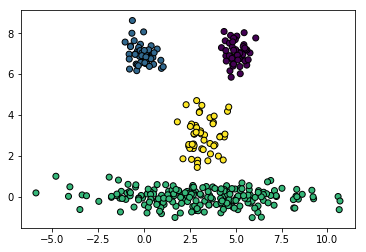

In [3]:
plt.scatter(X[:,0],X[:,1], edgecolors='k', c=[*map(lambda x: int(x[-1]), y),])
plt.show()

In [4]:
# "título" sem _ e cada palavra nova começa com maiusculo

# funções
# público. sem _ na frente
# modo protegido. nao aparece de primeira mas acessável quando da lda._ -> _ na frente
# modo privado. não acessivel -> __ na frente

# mesma coisa vale para os atributos da classe!
# em outras linguagens declaro na mão: publico tal privado tal

# no is_fitted posso passar atributos que ele pode verificar se ja foram calculados
# ['cov_', 'inv_cov_', 'mean_'])

class DiscriminantAnalysis(BaseEstimator, ClassifierMixin):
    
    def __init__(self, tipo='Linear'):
        self.tipo = tipo
    
    def fit(self, X, y):
        
        # verificando se a entrada faz sentido
        check_X_y(X, y)
        X = as_float_array(X)
        
        self.possible_values_ = np.unique(y)
        self.count_values_ = [(y == value).sum() for value in self.possible_values_]
        
        # calculando a matriz de covariância de cada classe
        cov_matrix = []
        for classe in self.possible_values_:
            cov_matrix.append(np.cov(np.array(X[y==classe]).T))
            
        # se usamos o tipo linear, agrupamos em um valor só
        if self.tipo == 'Linear':
            cov_matrix = [(tamanho-1)*matrix for matrix, tamanho in zip(cov_matrix,self.count_values_)]
            self.cov_ = [sum(cov_matrix)/(X.shape[0]-len(self.possible_values_))]*len(self.possible_values_)
            self.inv_cov_ = [np.linalg.inv(matriz) for matriz in self.cov_]
        
        if self.tipo == 'Quadrática':
            self.cov_ = cov_matrix
            self.inv_cov_ = [np.linalg.inv(matriz) for matriz in self.cov_]

        # calculando a média dos atributos em cada classe
        self.mean_ = []
        for classe in self.possible_values_:
            self.mean_.append(np.mean(X[y==classe],axis=0))
        return self
    
    def _calc_discrim(self, X):
        
        # calcula os discriminantes de cada classe
        g_ = []
        for i, tam_classe in enumerate(self.count_values_):
            if self.tipo == 'Linear':
                g_.append(np.matmul(np.matmul(X,self.inv_cov_[i]),self.mean_[i].T) - 0.5*np.matmul(np.matmul(self.mean_[i].T,self.inv_cov_[i]),self.mean_[i]) + np.log(tam_classe/sum(self.count_values_)))
            if self.tipo == 'Quadrática':
                g_.append(-0.5*np.matmul(np.matmul(X,self.inv_cov_[i]),X.T).diagonal() + np.matmul(np.matmul(self.mean_[i].T,self.inv_cov_[i]),X.T) - 0.5*np.matmul(np.matmul(self.mean_[i].T,self.inv_cov_[i]),self.mean_[i]) - 0.5*np.log(np.linalg.det(self.cov_[i])) + np.log(tam_classe/sum(self.count_values_)))
        return g_
    
    def predict(self, X):
        
        # verificando se já foi fitado
        check_is_fitted(self,  None)
        
        # verificando se a entrada faz sentido
        check_array(X)
        X = as_float_array(X)
        
        # calculando discriminantes
        g_ = self._calc_discrim(X)
        predict_ = []
        # retornando a classe com maior discriminante
        for i in range(X.shape[0]):
            aux = np.array([g_[j][i] for j in range(len(self.possible_values_))])
            predict_.append(self.possible_values_[np.argmax(aux)])
        return np.asarray(predict_)
        
    def predict_proba(self, X):
        
        # verificando se já foi fitado
        check_is_fitted(self, None)
        
        # verificando se a entrada faz sentido
        check_array(X)
        X = as_float_array(X)
        
        # calculando discriminantes
        g_ = self._calc_discrim(X)
        predict_ = []
        # soma os discriminantes para retornar uma "probabilidade"
        for i in range(X.shape[0]):
            aux = np.array([g_[j][i] for j in range(len(self.possible_values_))])
            predict_.append(aux/np.sum(aux))
        return np.asarray(predict_)

Linear

In [5]:
lda = DiscriminantAnalysis(tipo='Linear')
lda.fit(X,y)
lda_predict = lda.predict(X)

In [6]:
accuracy_score(lda_predict,y)

0.9971428571428571

In [7]:
resolucao = 100
x_vals = np.linspace(-7, 12, resolucao)
y_vals = np.linspace(-2, 10, resolucao)

Xgrid, Ygrid = np.meshgrid(x_vals, y_vals)
Z = np.array([*map(lambda x: int(x[-1]), lda.predict(np.column_stack((Xgrid.reshape(-1,1),Ygrid.reshape(-1,1))))),]).reshape(resolucao,resolucao)

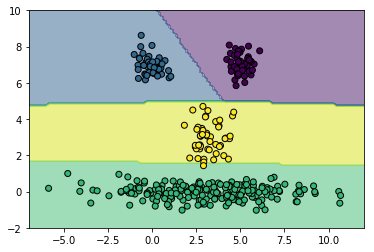

In [8]:
plt.contourf(Xgrid, Ygrid, Z, alpha = 0.5)
plt.scatter(X[:,0],X[:,1], edgecolors='k', c=[*map(lambda x: int(x[-1]), y),])
plt.show()

Quadrática

In [9]:
qda = DiscriminantAnalysis(tipo='Quadrática')
qda.fit(X,y)
qda_predict = qda.predict(X)

In [10]:
accuracy_score(qda_predict,y)

1.0

In [11]:
resolucao = 100
x_vals = np.linspace(-7, 12, resolucao)
y_vals = np.linspace(-2, 10, resolucao)

Xgrid, Ygrid = np.meshgrid(x_vals, y_vals)
Z = np.array([*map(lambda x: int(x[-1]), qda.predict(np.column_stack((Xgrid.reshape(-1,1),Ygrid.reshape(-1,1))))),]).reshape(resolucao,resolucao)

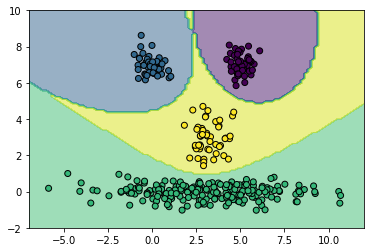

In [12]:
plt.contourf(Xgrid, Ygrid, Z, alpha = 0.5)
plt.scatter(X[:,0],X[:,1], edgecolors='k', c=[*map(lambda x: int(x[-1]), y),])
plt.show()

___

In [13]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [14]:
y_ = np.array([*map(lambda x: int(x[-1]), y),])

Teste LDA

In [15]:
lda_ = LinearDiscriminantAnalysis(solver='lsqr')

In [16]:
lda_.fit(X,y_)

LinearDiscriminantAnalysis(solver='lsqr')

In [17]:
Z_ = lda_.predict(np.column_stack((Xgrid.reshape(-1,1),Ygrid.reshape(-1,1)))).reshape(resolucao,resolucao)

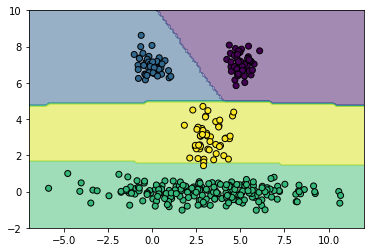

In [18]:
plt.contourf(Xgrid, Ygrid, Z_, alpha = 0.5)
plt.scatter(X[:,0],X[:,1], edgecolors='k', c=[*map(lambda x: int(x[-1]), y),])
plt.show()

Teste QDA

In [19]:
qda_ = QuadraticDiscriminantAnalysis(store_covariance=True)
qda_.fit(X,y_)
Z_ = qda_.predict(np.column_stack((Xgrid.reshape(-1,1),Ygrid.reshape(-1,1)))).reshape(resolucao,resolucao)

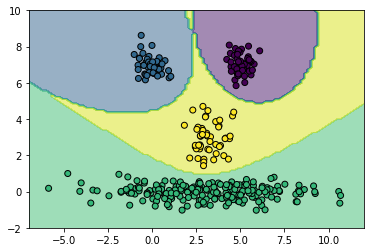

In [20]:
plt.contourf(Xgrid, Ygrid, Z_, alpha = 0.5)
plt.scatter(X[:,0],X[:,1], edgecolors='k', c=[*map(lambda x: int(x[-1]), y),])
plt.show()